# Personalized Medicine for Cancer Treatment based on Clinical Evidence

__Overview__<br>
The data set is comprised of two major components. The first is information about the genetic mutations while the other is the relevant clinical evidence in text form. The purpose of the original project is to develop methods to classify genetic mutations on collected clinical evidence. The idea is to aid specialists such as a pathologist who manually reviews and categorizes each genetic mutation using collected clinical evidence data. The Machine Learning Model would ideally utilize Natural Language Processing to read and classify the amino acid mutation/variation to the interpreted text from clinical assessments. Additionally, it is important that the model is clearly understandable as to aid specialists to make faster and more accurate decisions.<br>
There are a total of nine different possible genetic mutation classifications and the clinical evidence is structured in a format that has consistency between questions, such as a questionnaire.
Source of data<br>
Website:
https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/data <br>
API: kaggle competitions download -c msk-redefining-cancer-treatment

__Computational Component__<br>
The main task that I would like to focus on is developing a helper function to assess the information of the clinical evidence in the text format. The creation of an algorithm that can read medical literature would be the step the maximizes utility. The process would be to vectorize free text. Based on examples already completed, the effectiveness can be evaluated by using “vanilla logistic regression" and "random forest.

__Output__<br>
The output I expect is a matrix or a set of bar charts outlining the class of the amino acid chain variation based on the text data received.

In [1]:
import glob # file handling
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
from wordcloud import WordCloud # word cloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
input_files = glob.glob("/kaggle/input/**/*")
print("Available Input Filenames:\n", "\n".join(input_files))

Available Input Filenames:
 /kaggle/input/msk-redefining-cancer-treatment/training_text.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_variants.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage2_test_text.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/test_text.zip
/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip
/kaggle/input/msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z
/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip


In [3]:
training_text_filename = "/kaggle/input/msk-redefining-cancer-treatment/training_text.zip"
training_variants_filename = "/kaggle/input/msk-redefining-cancer-treatment/training_variants.zip"
test_text_filename = "/kaggle/input/msk-redefining-cancer-treatment/test_text.zip"
test_variants_filename = "/kaggle/input/msk-redefining-cancer-treatment/test_variants.zip"

In [4]:
training_text = pd.read_csv(training_text_filename, 
                           compression="zip", sep='\|\|', header=None, skiprows=1,
                           names=["ID","Text"], engine='python')
training_text

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
...,...,...
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...


In [5]:
test_text = pd.read_csv(test_text_filename, 
                        compression="zip", sep='\|\|', header=None, skiprows=1,
                        names=["ID","Text"], engine='python')
test_text

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...
...,...,...
5663,5663,The realization in the late 1970s that RAS har...
5664,5664,Hemizygous deletions are common molecular abno...
5665,5665,All most R267W of has with to SMARTpool invest...
5666,5666,Abstract Blood samples from 125 unrelated fami...


In [6]:
training_variants = pd.read_csv(training_variants_filename,
                                compression="zip")
training_variants

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
...,...,...,...,...
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4


In [7]:
test_variants = pd.read_csv(test_variants_filename,
                            compression="zip")
test_variants

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A
...,...,...,...
5663,5663,SLC46A1,R113S
5664,5664,FOXC1,L130F
5665,5665,GSS,R267W
5666,5666,CTSK,G79E


In [8]:
training_df = training_variants.merge(training_text, how="left", on="ID")
training_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
test_df = test_variants.merge(test_text, how="left", on="ID")
test_df.head()

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [10]:
print(training_df.shape)
print(test_df.shape)

(3321, 5)
(5668, 4)


In [11]:
# Step 1: Data Preprocessing
training_df = training_df.dropna()
test_df = test_df.dropna()
training_df['Text'] = training_df['Text'].apply(lambda text: text.lower())
test_df['Text'] = test_df['Text'].apply(lambda text: text.lower())

In [12]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the label encoder on the combined 'Gene' columns from both training and test data
all_genes = pd.concat([training_df['Gene'], test_df['Gene']], axis=0)
label_encoder.fit(all_genes)

# Transform the 'Gene' column in both training_df and test_df
training_df['Gene'] = label_encoder.transform(training_df['Gene'])
test_df['Gene'] = label_encoder.transform(test_df['Gene'])

In [13]:
# Create a LabelEncoder object
label_encoder_var = LabelEncoder()

# Fit the label encoder on the combined 'Gene' columns from both training and test data
all_genes = pd.concat([training_df['Variation'], test_df['Variation']], axis=0)
label_encoder_var.fit(all_genes)

# Transform the 'Gene' column in both training_df and test_df
training_df['Variation'] = label_encoder_var.transform(training_df['Variation'])
test_df['Variation'] = label_encoder_var.transform(test_df['Variation'])

In [14]:
training_df.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         0
dtype: int64

In [15]:
training_df.shape

(3316, 5)

In [16]:
# Preprocess the text data and convert it into a list of abstracts
abstracts = training_df['Text']

# Define few stop words
stop_words = ['.','al','et','wt','fig','used','figure','case','cases','using','type','shown',
              'table','line','000','10','30','15','20','40','100','37','48','27','13','12','01',
              '2009','21','23','2010','05','2007','2013','60','2012','44','18','2011','46','001',
              '38','61','2000','56','70','14','45','16','11','24','57','25','50','58','80','17',
              '59','54','33','35','29','31','36','19','22','34','00','2008','2006','2004','2001',
              '1997','1996','95','55','2003','2005','2002','42','41','1999','1998','39','32','26',
              '43','52','75','47','28','200','72','51','90','49','lines','showed','kd','mm','bp',
              'd1','μm','μl','rt','ml','ca','ha','e2','s2','3a','s1','ba','f3','ng','il','ph','sd',
              '4a','1b','ii','1a','2a','μg','2b','s3','mg','vs','ci','hr','1c','nm','ar','pa','pr',
              '3b','er','4b','did','iii','150','1994','1995','293t','2c','3c','3t3','4c','500','53',
              '64','65','96','aa','500','5a']
# Merge 'english' and custom stop words into a single list
stop_words = list(TfidfVectorizer(stop_words='english').get_stop_words()) + stop_words
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)

# Fit and transform the abstracts to obtain TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)
# Get the feature names (words) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

In [17]:
# Reset the index of training_df to match the row numbers with tfidf_matrix
training_df.reset_index(drop=True, inplace=True)
X = pd.concat([training_df[['Gene','Variation']], pd.DataFrame(tfidf_matrix.toarray())], axis=1)
X.columns = ['Gene','Variation'] + list(feature_names)
y = training_df['Class']

In [18]:
X

,Gene,Variation,aberrant,ability,abl,able,absence,according,accumulation,acid,...,vuss,washed,weeks,western,wild,work,www,year,years,yeast
0,446,7651,0.010593,0.003586,0.000000,0.000000,0.010566,0.006828,0.000000,0.015691,...,0.0,0.020908,0.000000,0.068580,0.008846,0.009157,0.000000,0.000000,0.000000,0.025477
1,215,8252,0.000000,0.000000,0.007419,0.000000,0.000000,0.005341,0.000000,0.001637,...,0.0,0.021807,0.000000,0.004208,0.010764,0.000000,0.000000,0.006033,0.002417,0.000000
2,215,5189,0.000000,0.000000,0.007419,0.000000,0.000000,0.005341,0.000000,0.001637,...,0.0,0.021807,0.000000,0.004208,0.010764,0.000000,0.000000,0.006033,0.002417,0.000000
3,215,4570,0.008496,0.002876,0.017117,0.006642,0.011300,0.002738,0.004687,0.002517,...,0.0,0.008385,0.000000,0.000000,0.037843,0.000000,0.000000,0.000000,0.007434,0.000000
4,215,3956,0.000000,0.003503,0.000000,0.000000,0.000000,0.020009,0.000000,0.003065,...,0.0,0.005106,0.000000,0.000000,0.028804,0.002236,0.000000,0.000000,0.002263,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3311,1153,960,0.000000,0.019972,0.000000,0.008648,0.002452,0.028523,0.008136,0.019664,...,0.0,0.007279,0.008107,0.022470,0.043114,0.012751,0.000000,0.004027,0.012907,0.000000
3312,1153,56,0.000000,0.010317,0.000000,0.007941,0.003378,0.016371,0.000000,0.000000,...,0.0,0.005013,0.011168,0.015476,0.002828,0.017564,0.000000,0.005547,0.000000,0.000000
3313,1153,2076,0.000000,0.001140,0.000000,0.000000,0.000000,0.001086,0.000000,0.003992,...,0.0,0.000000,0.000000,0.000000,0.005627,0.000000,0.000000,0.001840,0.001474,0.000000
3314,1153,6604,0.000000,0.000000,0.000000,0.000000,0.000000,0.002121,0.000000,0.005850,...,0.0,0.000000,0.000000,0.000000,0.009162,0.002845,0.000000,0.000000,0.008640,0.000000


In [19]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Train the Random Forest model with cross-validation
random_forest_model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(random_forest_model, X, y, cv=5)  # 5-fold cross-validation

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Scores: [0.50903614 0.48717949 0.44645551 0.61689291 0.47963801]
Mean Cross-Validation Accuracy: 0.5078404114194334


In [20]:
# Train the Random Forest model on the entire training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the validation data
y_pred_val = random_forest_model.predict(X_val)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Validation Accuracy: 0.6355421686746988
              precision    recall  f1-score   support

           1       0.57      0.60      0.59       118
           2       0.72      0.42      0.53       105
           3       0.39      0.45      0.42        20
           4       0.66      0.71      0.68       135
           5       0.57      0.43      0.49        47
           6       0.76      0.62      0.68        42
           7       0.64      0.81      0.72       188
           8       0.00      0.00      0.00         3
           9       0.80      0.67      0.73         6

    accuracy                           0.64       664
   macro avg       0.57      0.52      0.54       664
weighted avg       0.64      0.64      0.63       664



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Fit and transform the abstracts to obtain TF-IDF matrix
tfidf_test = tfidf_vectorizer.transform(test_df['Text'])

# Reset the index of training_df to match the row numbers with tfidf_matrix
test_df.reset_index(drop=True, inplace=True)
X_test = pd.concat([test_df[['Gene','Variation']], pd.DataFrame(tfidf_test.toarray())], axis=1)
X_test.columns = ['Gene','Variation'] + list(feature_names)

In [22]:
# Predict using the trained models on the test data
y_pred_test_rf = random_forest_model.predict(X_test)
print(y_pred_test_rf)

# Get the counts of each class label in the predicted results
unique_labels, label_counts = np.unique(y_pred_test_rf, return_counts=True)
print(unique_labels, label_counts)

[7 4 7 ... 2 7 4]
[1 2 3 4 5 6 7 9] [1065  326   10  583   38   36 3606    3]


In [23]:
test_df['Class'] = y_pred_test_rf
test_df

,ID,Gene,Variation,Text,Class
0,0,28,6402,2. this mutation resulted in a myeloproliferat...,7
1,1,850,5003,abstract the large tumor suppressor 1 (lats1)...,4
2,2,948,3913,vascular endothelial growth factor receptor (v...,7
3,3,655,85,inflammatory myofibroblastic tumor (imt) is a ...,7
4,4,1374,2779,abstract retinoblastoma is a pediatric retina...,1
...,...,...,...,...,...
5662,5663,1260,5377,the realization in the late 1970s that ras har...,7
5663,5664,484,3682,hemizygous deletions are common molecular abno...,7
5664,5665,574,5890,all most r267w of has with to smartpool invest...,2
5665,5666,313,2784,abstract blood samples from 125 unrelated fami...,7


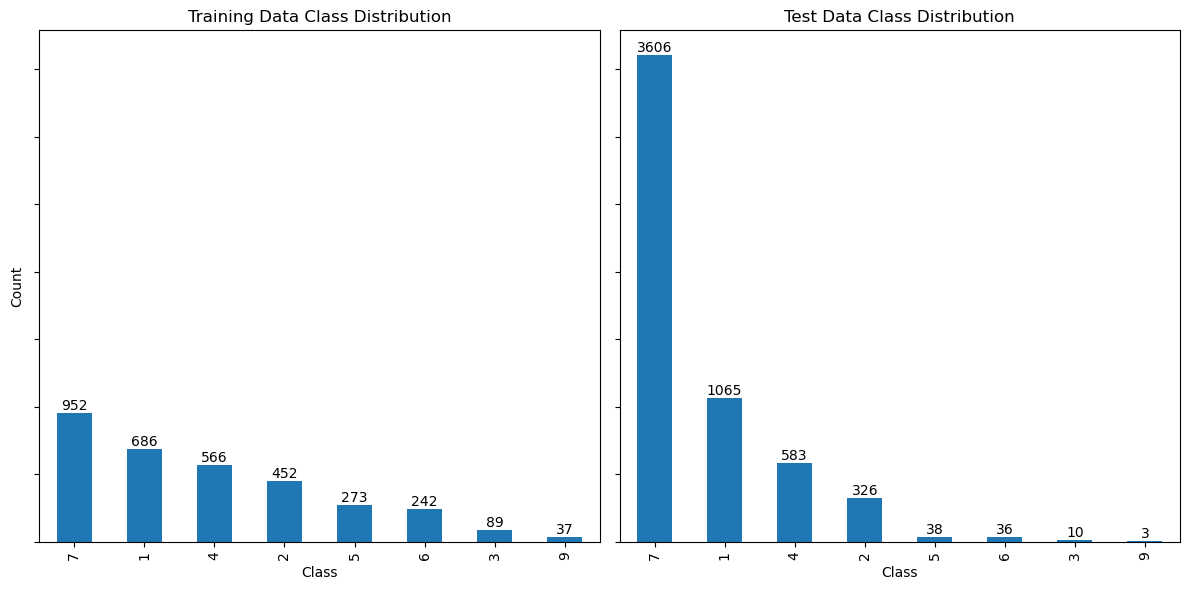

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded the training_df and test_df DataFrames

# Get the 'Class' column from both DataFrames and compute the counts
train_class_counts = training_df['Class'].value_counts()
test_class_counts = test_df['Class'].value_counts()

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Bar plot for training_df['Class']
train_plot = train_class_counts.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Training Data Class Distribution')

# Add count values on top of each bar
for p in train_plot.patches:
    ax1.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Remove y-axis tick labels
ax1.set_yticklabels([])

# Bar plot for test_df['Class']
test_plot = test_class_counts.plot(kind='bar', ax=ax2)
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Test Data Class Distribution')

# Add count values on top of each bar
for p in test_plot.patches:
    ax2.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Remove y-axis tick labels
ax2.set_yticklabels([])

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [25]:
# Select the top-n words with the highest TF-IDF scores as important keywords for each abstract
top_n_keywords = 10  # Change this value to get a different number of keywords
important_keywords_per_abstract = []
for row in tfidf_matrix.toarray():
    # Get the indices of the words with the highest TF-IDF scores
    top_indices = row.argsort()[::-1][:top_n_keywords]
    keywords = [feature_names[index] for index in top_indices]
    important_keywords_per_abstract.append(keywords)
    
training_df['top_keywords'] = list(map(",".join, important_keywords_per_abstract))

In [26]:
training_df

,ID,Gene,Variation,Class,Text,top_keywords
0,0,446,7651,1,cyclin-dependent kinases (cdks) regulate a var...,"cyclin,cells,syndrome,expression,gst,levels,pr..."
1,1,215,8252,2,abstract background non-small cell lung canc...,"cbl,egfr,lung,loh,met,mutations,cell,mutation,..."
2,2,215,5189,2,abstract background non-small cell lung canc...,"cbl,egfr,lung,loh,met,mutations,cell,mutation,..."
3,3,215,4570,3,recent evidence has demonstrated that acquired...,"cbl,flt3,mutations,jak2,mutation,ubiquitin,tyr..."
4,4,215,3956,4,oncogenic mutations in the monomeric casitas b...,"cbl,mutations,stability,cancer,binding,egfr,ub..."
...,...,...,...,...,...,...
3311,3316,1153,960,4,introduction myelodysplastic syndromes (mds) ...,"aml,mice,cells,mutations,mutants,mouse,leukemi..."
3312,3317,1153,56,1,introduction myelodysplastic syndromes (mds) ...,"mice,aml,cells,mouse,transduced,expression,mar..."
3313,3318,1153,2076,1,the runt-related transcription factor 1 gene (...,"runx1,aml,fusion,gene,translocation,genes,prot..."
3314,3319,1153,6604,4,the runx1/aml1 gene is the most frequent targe...,"runx1,aml,leukemia,mutations,mutation,point,do..."


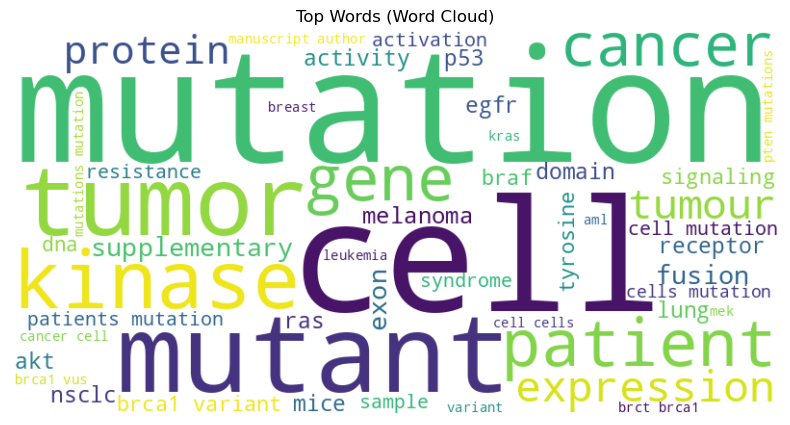

In [27]:
# Combine all extracted keywords into a single list
all_keywords = [keyword for keywords_list in important_keywords_per_abstract for keyword in keywords_list]

# Create a word cloud to visualize the top words
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(' '.join(all_keywords))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words (Word Cloud)')
plt.show()

In [28]:
# Select the top-n words with the highest TF-IDF scores as important keywords for each abstract
top_n_keywords = 10  # Change this value to get a different number of keywords
important_keywords_per_abstract = []
for row in tfidf_test.toarray():
    # Get the indices of the words with the highest TF-IDF scores
    top_indices = row.argsort()[::-1][:top_n_keywords]
    keywords = [feature_names[index] for index in top_indices]
    important_keywords_per_abstract.append(keywords)
    
test_df['top_keywords'] = list(map(",".join, important_keywords_per_abstract))

In [29]:
test_df

,ID,Gene,Variation,Text,Class,top_keywords
0,0,28,6402,2. this mutation resulted in a myeloproliferat...,7,"egfr,jak2,l858r,patients,mutation,mutations,ge..."
1,1,850,5003,abstract the large tumor suppressor 1 (lats1)...,4,"gst,myc,ubiquitin,flag,ligase,degradation,e3,c..."
2,2,948,3913,vascular endothelial growth factor receptor (v...,7,"erbb2,cells,mtor,akt,serum,cancer,breast,metas..."
3,3,655,85,inflammatory myofibroblastic tumor (imt) is a ...,7,"cyclin,alk,kinase,ros1,fusions,akt,cells,crizo..."
4,4,1374,2779,abstract retinoblastoma is a pediatric retina...,1,"cbl,egfr,cells,egf,min,p53,cell,mapk,degradati..."
...,...,...,...,...,...,...
5662,5663,1260,5377,the realization in the late 1970s that ras har...,7,"ras,oncogenic,smad,apoptotic,cells,mutations,s..."
5663,5664,484,3682,hemizygous deletions are common molecular abno...,7,"syndrome,genes,deletions,ras,cells,deletion,tr..."
5664,5665,574,5890,all most r267w of has with to smartpool invest...,2,"patients,imatinib,response,dose,tumor,tumors,m..."
5665,5666,313,2784,abstract blood samples from 125 unrelated fami...,7,"akt,ovarian,akt1,cell,mutations,age,families,y..."


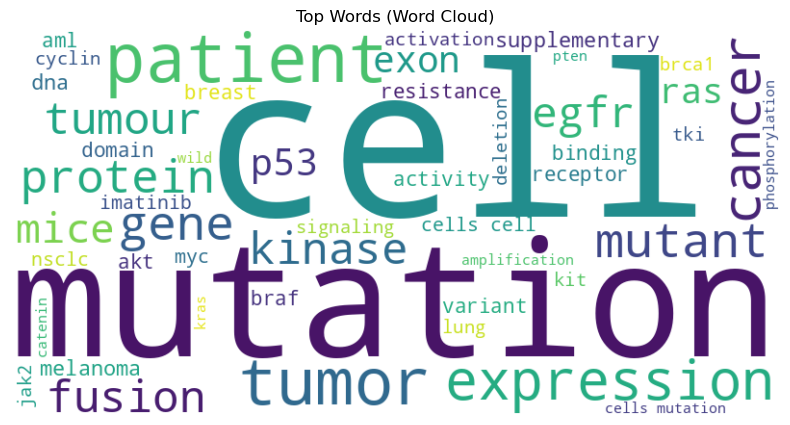

In [30]:
# Combine all extracted keywords into a single list
all_keywords = [keyword for keywords_list in important_keywords_per_abstract for keyword in keywords_list]

# Create a word cloud to visualize the top words
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(' '.join(all_keywords))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words (Word Cloud)')
plt.show()